In [1]:
import numpy as np
import h5py

from matplotlib import pyplot as plt
import seaborn as sns

from scipy.signal import argrelextrema, argrelmin, argrelmax

In [2]:
sns.set_style('whitegrid')

In [3]:
img_planet = h5py.File('/work/ka1176/shared_data/2021-ai4food/dev_data/germany/planet/extracted/train_data.h5', 'r')['image_stack'][:]
img_planet_test = h5py.File('/work/ka1176/shared_data/2021-ai4food/dev_data/germany/planet/extracted/test_data.h5', 'r')['image_stack'][:]
img_sentinel1 = h5py.File('/work/ka1176/shared_data/2021-ai4food/dev_data/germany/sentinel-1/extracted/train_data.h5', 'r')['image_stack'][:]
img_sentinel1_test = h5py.File('/work/ka1176/shared_data/2021-ai4food/dev_data/germany/sentinel-1/extracted/test_data.h5', 'r')['image_stack'][:]
img_sentinel2 = h5py.File('/work/ka1176/shared_data/2021-ai4food/dev_data/germany/sentinel-2/extracted/train_data.h5', 'r')['image_stack'][:]
labels = h5py.File('/work/ka1176/shared_data/2021-ai4food/dev_data/germany/sentinel-2/extracted/train_data.h5', 'r')['label'][:]

In [4]:
img_planet.shape, img_sentinel1.shape, img_sentinel2.shape, labels.shape

((2504, 365, 4, 64), (2504, 118, 3, 64), (2504, 144, 13, 64), (2504,))

In [5]:
np.unique(labels, return_counts=True)

(array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([302, 276, 136,  44, 248, 201,  21, 943, 333]))

In [6]:
planet_ndvi = (img_planet[:, :, 3] - img_planet[:, :, 2]) / (img_planet[:, :, 3] + img_planet[:, :, 2])
planet_ndvi_test = (img_planet_test[:, :, 3] - img_planet_test[:, :, 2]) / (img_planet_test[:, :, 3] + img_planet_test[:, :, 2])

In [7]:
t_ndvi = np.arange(365) / 30 + 1

m_ndvi_planet = np.mean(planet_ndvi, axis=(0, 2))
m_ndvi_planet_test = np.mean(planet_ndvi_test, axis=(0, 2))

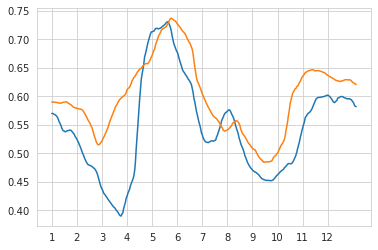

In [8]:
plt.plot(t_ndvi, m_ndvi_planet)
plt.plot(t_ndvi, m_ndvi_planet_test)
plt.xticks(np.arange(1, 13))
plt.show()

In [19]:
veg_planet_train = argrelmin(m_ndvi_planet, order=60)[0]
veg_planet_test  = argrelmin(m_ndvi_planet_test, order=60)[0]
veg_length = veg_planet_train[1] - veg_planet_train[0]
print(veg_planet_train, veg_planet_test, veg_length)


[ 83 262] [ 56 255] 179


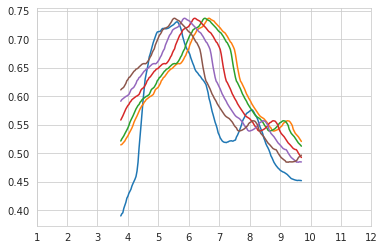

In [24]:

plt.plot(t_ndvi[veg_planet_train[0]:veg_planet_train[0]+veg_length], m_ndvi_planet[veg_planet_train[0]:veg_planet_train[0]+veg_length])
for k in [56, 60, 70, 80, 90]:
    plt.plot(t_ndvi[veg_planet_train[0]:veg_planet_train[0]+veg_length], m_ndvi_planet_test[k:k+veg_length])
plt.xticks(np.arange(1, 13))
plt.show()

In [11]:
def _calc_rvi(X, rvi_filter=False):
    VV = X[:,:,0,:]
    VH = X[:,:,1,:]
    dop = (VV/(VV+VH))
    m = 1 - dop
    radar_vegetation_index = (np.sqrt(dop))*((4*(VH))/(VV+VH))
    
    return radar_vegetation_index

In [12]:
rvi_sentinel1_train = _calc_rvi(img_sentinel1)
rvi_sentinel1_test = _calc_rvi(img_sentinel1_test)

<ipython-input-11-28c8cb2debb5>:4: RuntimeWarning: invalid value encountered in true_divide
  dop = (VV/(VV+VH))
<ipython-input-11-28c8cb2debb5>:6: RuntimeWarning: invalid value encountered in true_divide
  radar_vegetation_index = (np.sqrt(dop))*((4*(VH))/(VV+VH))


In [13]:
m_rvi_sentinel1_train = np.nanmean(rvi_sentinel1_train[:, ::2], axis=(0,2))
m_rvi_sentinel1_train_odd = np.nanmean(rvi_sentinel1_train[:, 1::2], axis=(0,2))

m_rvi_sentinel1_test = np.nanmean(rvi_sentinel1_test[:, ::2], axis=(0,2))
m_rvi_sentinel1_test_odd = np.nanmean(rvi_sentinel1_test[:, 1::2], axis=(0,2))

In [14]:
ix_start = int(veg_planet_train[0] * (len(m_rvi_sentinel1_train) / len(m_ndvi_planet)))
ix_start_test = int(veg_planet_test[0] * (len(m_rvi_sentinel1_test) / len(m_ndvi_planet)))


ix_end = int(veg_planet_train[1] * (len(m_rvi_sentinel1_train) / len(m_ndvi_planet)))

print(ix_start, ix_end)

t_sentinel1 = np.linspace(0, 365, len(m_rvi_sentinel1_train)) / 30 + 1

13 42


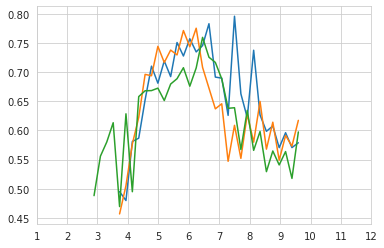

In [15]:
plt.plot(t_sentinel1[ix_start:ix_end], m_rvi_sentinel1_train[ix_start:ix_end])
plt.plot(t_sentinel1[ix_start:ix_end], m_rvi_sentinel1_train_odd[ix_start:ix_end])

plt.plot(t_sentinel1[ix_start_test:ix_end], m_rvi_sentinel1_test[ix_start_test:ix_end])

plt.xticks(np.arange(1, 13))
plt.show()

In [16]:
sentinel2_ndvi = (img_sentinel2[:, :, 7] - img_sentinel2[:, :, 3]) / (img_sentinel2[:, :, 7] + img_sentinel2[:, :, 3])

sentinel2_nli = (img_sentinel2[:, :, 8] - img_sentinel2[:, :, 4]) / (img_sentinel2[:, :, 8] + img_sentinel2[:, :, 4])

sentinel2_nmi = (img_sentinel2[:, :, 8] - img_sentinel2[:, :, 10]) / (img_sentinel2[:, :, 8] + img_sentinel2[:, :, 10])

sentinel2_ndi = (img_sentinel2[:, :, 8] - (img_sentinel2[:, :, 10] - img_sentinel2[:, :, 11])) / (img_sentinel2[:, :, 8] + (img_sentinel2[:, :, 10] - img_sentinel2[:, :, 11]))

<ipython-input-16-c84f5abda50b>:1: RuntimeWarning: invalid value encountered in true_divide
  sentinel2_ndvi = (img_sentinel2[:, :, 7] - img_sentinel2[:, :, 3]) / (img_sentinel2[:, :, 7] + img_sentinel2[:, :, 3])
<ipython-input-16-c84f5abda50b>:3: RuntimeWarning: invalid value encountered in true_divide
  sentinel2_nli = (img_sentinel2[:, :, 8] - img_sentinel2[:, :, 4]) / (img_sentinel2[:, :, 8] + img_sentinel2[:, :, 4])
<ipython-input-16-c84f5abda50b>:5: RuntimeWarning: invalid value encountered in true_divide
  sentinel2_nmi = (img_sentinel2[:, :, 8] - img_sentinel2[:, :, 10]) / (img_sentinel2[:, :, 8] + img_sentinel2[:, :, 10])
<ipython-input-16-c84f5abda50b>:7: RuntimeWarning: invalid value encountered in true_divide
  sentinel2_ndi = (img_sentinel2[:, :, 8] - (img_sentinel2[:, :, 10] - img_sentinel2[:, :, 11])) / (img_sentinel2[:, :, 8] + (img_sentinel2[:, :, 10] - img_sentinel2[:, :, 11]))


In [17]:

cld_sentinel2 = np.nanmean(img_sentinel2[:, :, -1], axis=(0, 2)) * 1e4 / 255

sentinel2_ndvi.shape

t_sentinel2 = np.linspace(0, 365, 144) / 30 + 1

m_ndvi_sentinel2 = np.nanmean(sentinel2_ndvi, axis=(0,2))

good_ix = np.where(cld_sentinel2 < 0.1)[0]

print(good_ix)

[ 30  37  38  39  43  47  49  50  51  53  58  61  62  72  80  81  83  86
  90  92  97  98  99 103 107 112 113]


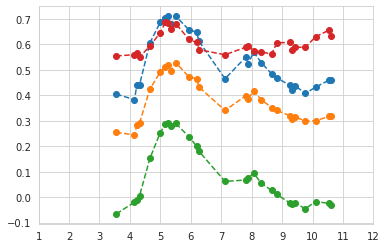

In [18]:
plt.plot(t_sentinel2[good_ix], m_ndvi_sentinel2[good_ix], 'o--')
plt.plot(t_sentinel2[good_ix], np.nanmean(sentinel2_nli, axis=(0,2))[good_ix], 'o--')
plt.plot(t_sentinel2[good_ix], np.nanmean(sentinel2_nmi, axis=(0,2))[good_ix], 'o--')
plt.plot(t_sentinel2[good_ix], np.nanmean(sentinel2_ndi, axis=(0,2))[good_ix], 'o--')

plt.xticks(range(1, 13))
plt.show()